# Задание 1. A/B–тестирование

## Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss

# библиотеки для чтения данных
import requests as r
import json

%matplotlib inline

## Входные данные

В качестве входных данных имеется 4 csv-файла:

- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
    
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
    
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 
    
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


## Считывание данных

In [2]:
# Функция для считывания данных с Яндекс Диска

def read_csv_file(link):
    file = r.get(f'https://cloud-api.yandex.net/v1/disk/public/resources?public_key={link}').json()['file']
     # при помощи параметра engine='python' в параметре sep удалось учесть несколько разделителей
    df = pd.read_csv(file, sep=';|,', engine='python')
    return df

In [3]:
# Ссылки на данные

groups_link = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add_link = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs_link = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks_link = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [4]:
# Считывание данных

groups_df = read_csv_file(groups_link)
groups_add_df = read_csv_file(groups_add_link)
active_studs_df = read_csv_file(active_studs_link)
checks_df = read_csv_file(checks_link)

## Работа с исходными таблицами

In [5]:
# Проверка на корректность данных: в доп файле не дублируется id пользователя

groups_add_df.id.isin(groups_df.id).sum()

0

In [6]:
# Переименовал колонки

active_studs_df = active_studs_df.rename(columns={'"student_id"': 'id'})
checks_df = checks_df.rename(columns={'"student_id"': 'id', '"rev"': 'rev'})

Работа с таблицей checks_df

In [7]:
# Количество строк в таблице checks_df

checks_df.shape[0]

541

In [8]:
# Количество уникальных значений id в таблице checks_df

checks_df.id.nunique()

541

Количество уникальных значений id в таблице checks_df равно количеству строк.

Значит каждый пользователь, совершивший платное действие, произвел одну оплату в дни проведения тестирования.

In [9]:
# Совместил всех пользователей участвующих в A/B-тестировании 

all_users = pd.concat([groups_df, groups_add_df], ignore_index=True)

Применяю left join для таблицы с юзерами, которые зашли на платформу в дни проведения эксперемента с таблицой, содержащей всех пользователей, участвующих в A/B-тестировании.

Далее работаю с данной таблицей.

In [10]:
active_users = active_studs_df.merge(all_users, how='left', on='id')

In [11]:
# Джойн выполнен успешно

active_users.isnull().sum()

id     0
grp    0
dtype: int64

In [12]:
# Количество строк в таблице

active_users.shape[0]

8341

In [13]:
# Джойн всех активных пользователей с пользователями совершившими оплату

active_users = active_users.merge(checks_df, how='left', on='id').fillna(0)

In [14]:
# Создаю колонку с фактом оплаты, где 0 - не было оплаты, 1 - была оплата

active_users['is_purchase'] = np.where(active_users.rev > 0, 1, 0)
active_users

,id,grp,rev,is_purchase
0,581585,A,0.0,0
1,5723133,A,0.0,0
2,3276743,B,0.0,0
3,4238589,A,0.0,0
4,4475369,B,0.0,0
...,...,...,...,...
8336,1794344,B,0.0,0
8337,296883,B,0.0,0
8338,3598448,B,0.0,0
8339,3610547,B,290.0,1


In [15]:
# 392 пользователя, участвующих в тестировании, совершили оплату

active_users.is_purchase.sum()

392

## Расчет метрик

In [16]:
# Датафрейм для расчета метрик 

metrics = active_users \
    .groupby('grp', as_index=False) \
    .agg({'id': 'count', 'is_purchase': 'sum', 'rev': 'sum'}) \
    .rename(columns={'grp': 'group', 'id': 'users_count', 'rev': 'revenue', 'is_purchase': 'purchase_count'}, index={0: 'control', 1: 'target'})

In [17]:
# Конверсия пользователя в покупку

metrics['CR'] = metrics.purchase_count / metrics.users_count

In [18]:
# Средний доход на пользователя

metrics['ARPU'] = metrics.revenue / metrics.users_count

In [19]:
# Средний доход на платящего пользователя (клиента)

metrics['ARPPU'] = metrics.revenue / metrics.purchase_count

In [20]:
metrics

,group,users_count,purchase_count,revenue,CR,ARPU,ARPPU
control,A,1538,78,72820.0000,0.050715,47.347204,933.589744
target,B,6803,314,394974.0035,0.046156,58.058798,1257.878992


## Проведение A/B-тестирования

В результате проведения A/B-тестирования будет решено, стоит ли внедрять новую механику оплаты на всех пользователей или нет. 

### Тест №1

В качестве первого теста я использую критерий хи-квадрат. При его проведение я опираюсь на CR пользователя в покупку. На вход функции подается таблица сопряженности с количеством пользователей разных групп с оплатой и без.

Выдвигаю гипотезы:

- H0: новая механика оплаты услуг на сайте не влияет на конверсию пользователей в покупку

- H1: новая механика оплаты услуг на сайте влияет на конверсию пользователей в покупку

In [21]:
# Общая настройка графиков для всего файла

sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={'figure.figsize':(18,7)}
)

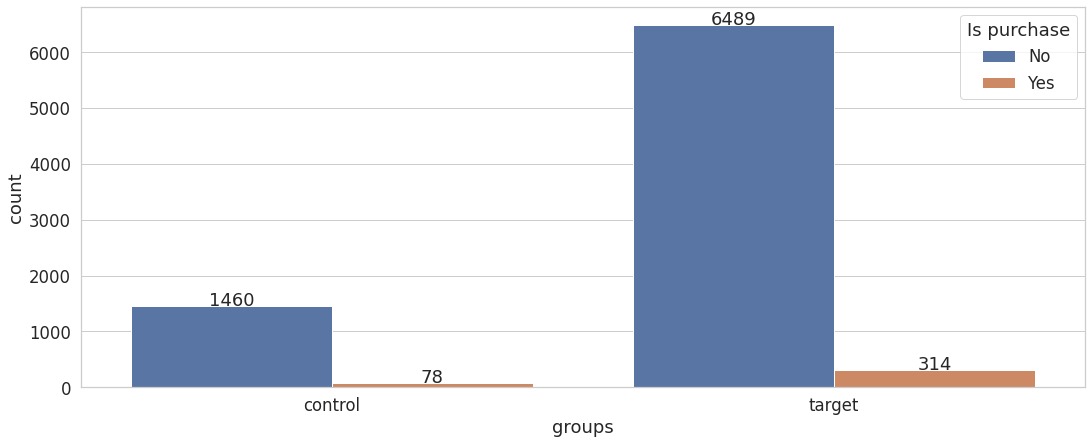

In [22]:
# График, отображающий конверсию пользователей в покупку

ax = sns.countplot(data=active_users, x='grp', hue='is_purchase')
ax.set(xticklabels=['control', 'target'], xlabel='groups')
ax.legend(title='Is purchase', labels=['No', 'Yes'])

for i in ax.patches:
    ax.annotate(f'{i.get_height()}', (i.get_x() + i.get_width() / 2, i.get_height()), ha='center')

In [23]:
# Создаю таблицу сопряженности

test_1 = pd.crosstab(active_users.grp, active_users.is_purchase)
test_1

is_purchase,0,1
grp,,
A,1460,78
B,6489,314


In [24]:
# Применяю критерий хи-квадрат

ss.chi2_contingency(test_1)

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854,   72.28102146],
        [6483.28102146,  319.71897854]]))

Значение p-value равно ~0.48, что сильно больше 0.05, значит у нас нет основания отклонить нулевую гипотезу, следовательно новая механика оплаты услуг на сайте не влияет на конверсию пользователей в покупку.

### Тест №2

Для второго теста я также буду использовать критерий хи-квадрат. В этом случае я буду опираться на метрику ARPPU. На вход функции подается таблица сопряженности с количеством пользователей совершивших покупку и доходом от этих пользователей.

Гипотезы:

- H0: новая механика оплаты услуг на сайте не влияет на средний доход от платящего пользователя

- H1: новая механика оплаты услуг на сайте влияет на средний доход от платящего пользователя

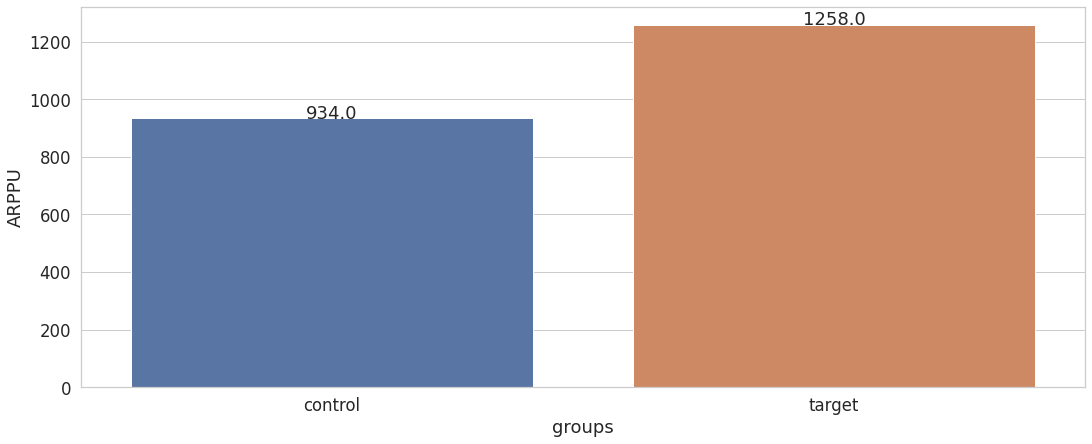

In [25]:
# График ARPPU по целевой и контрольной группам

ax = sns.barplot(data=metrics, x='group', y='ARPPU')
ax.set(xticklabels=['control', 'target'], xlabel='groups')

for i in ax.patches:
    ax.annotate(f'{round(i.get_height(), 0)}', (i.get_x() + i.get_width() / 2, i.get_height()), ha='center')

In [26]:
# Создаю таблицу сопряженности

test_2 = metrics[['purchase_count', 'revenue']]
test_2

,purchase_count,revenue
control,78,72820.0000
target,314,394974.0035


In [27]:
# Применяю критерий хи-квадрат

ss.chi2_contingency(test_2)

(5.264739226632414,
 0.021761682832048438,
 1,
 array([[6.10356051e+01, 7.28369644e+04],
        [3.30964395e+02, 3.94957039e+05]]))

Значение p-value меньше 0.05, что дает основание отклонить нулевую гипотезу в пользу альтернативной. Можно полагать, что новая механика оплаты услуг на сайте влияет на средний доход от платящего пользователя.

### Тест №3

Для оценки новой механики оплаты, в качестве третьего теста, я буду использовать распределения дохода от платящих пользователей(клиентов) контрольной и целевой групп.

Гипотезы:

- H0: новая механика оплаты услуг на сайте не влияет на доход от платящих пользователей

- H1: новая механика оплаты услуг на сайте влияет на доход от платящих пользователей

[Text(0, 0.5, 'revenue'),
 [Text(0, 0, 'control'), Text(0, 0, 'target')],
 Text(0.5, 0, 'groups')]

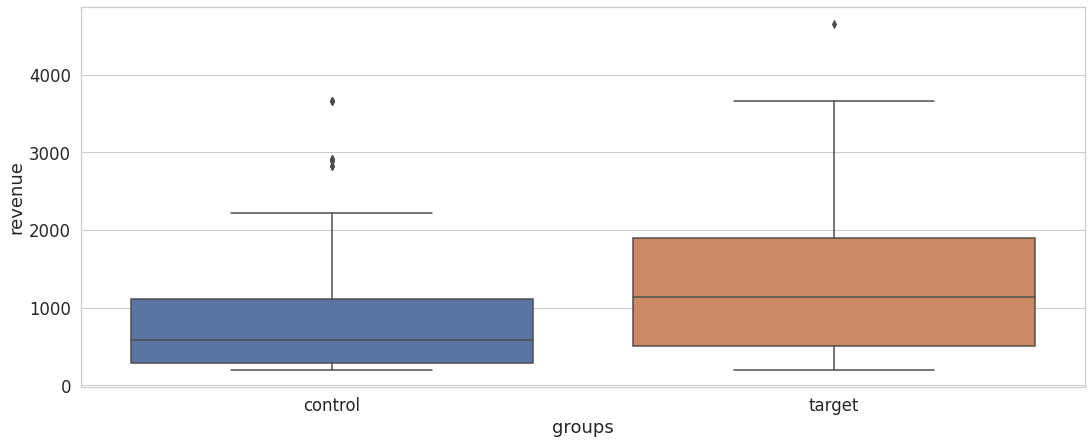

In [28]:
# Распределения дохода от платящих пользователей целевой и контрольной групп

ax = sns.boxplot(data=active_users.loc[active_users.rev > 0], x='grp', y='rev')
ax.set(xticklabels=['control', 'target'], xlabel='groups', ylabel='revenue')

In [29]:
# Пандас серия дохода от платящих пользователей контрольной группы

revenue_control_series = active_users.query('rev > 0 and grp == "A"').rev

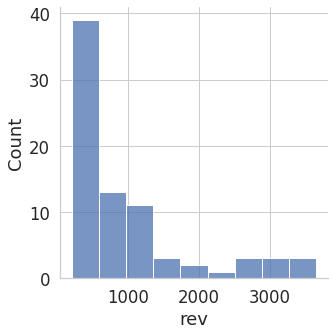

In [30]:
# Распределение дохода платящих пользователей контрольной группы

sns.displot(revenue_control_series)

In [31]:
# Пандас серия дохода от платящих пользователей целевой группы

revenue_target_series = active_users.query('rev > 0 and grp == "B"').rev

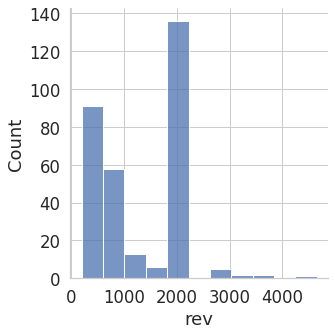

In [32]:
# Распределение дохода платящих пользователей целевой группы

sns.displot(revenue_target_series)

По графикам видно, что распределения не являются нормальными, но для подтвержения этого факта я проведу проверки на нормальность.

In [33]:
ss.normaltest(revenue_control_series)

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)

In [34]:
ss.normaltest(revenue_target_series)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

Распределения не прошли проверку на нормальность, значит t-критерий Стьюдента использовать нельзя. Вместо него можно применить критерий Манна-Уитни или метод bootstrap. Для достоверности результата я проведу оба теста.

In [35]:
# Применяю bootstrap для контрольной группы

ss.bootstrap((revenue_control_series, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=751.9610099357125, high=1164.2018914045357), standard_error=103.96505893719717)

In [36]:
# Применяю bootstrap для целевой группы

ss.bootstrap((revenue_target_series, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1169.6925750191658, high=1347.240685091279), standard_error=44.70229231111399)

Доверительный интервал в контрольной группе - [756; 1163], в целевой - [1171; 1347]. Доверительные интервалы не пересекаются, значит есть основания отклонить нулевую гипотезу.

In [37]:
# Применяю критерий Манна-Уитни

ss.mannwhitneyu(revenue_control_series, revenue_target_series)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0002511393831406922)

Значение p-value равно ~0.00025 что сильно меньше 0.05, значит есть основания отклонить нулевую гипотезу в пользу альтернативной.

В обоих тестах была отклонена нулевая гипотеза, отсюда можно полагать, что новая механика оплаты услуг на сайте влияет на доход от платящих пользователей. 

## Вывод

Было проведено 3 статистических теста, в двух из которых была принята альтернативная гипотеза. Отсюда я могу сделать вывод, что новая механика оплаты услуг на сайте оказалась более эффективной по сравнению с базовой механикой. Я считаю, что новую механику оплаты услуг стоит внедрить для всех пользователей сайта. 